In [122]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [384]:
from tableGAN.utils import create_GAN_data, TabularDataset
from tableGAN.tableGAN import make_noise, CriticNet, WGAN, GeneratorNet

In [3]:
balance_ratio = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4 ,0.5]

In [70]:
for ratio in balance_ratio:
    real = create_GAN_data(20000,class_ratio=ratio,random_state=123)
    X = real.drop("group", axis=1)
    y = real.group.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify=y)

    clf = DecisionTreeClassifier(min_samples_leaf=50, random_state=123)
    clf.fit(X_train, y_train)
    pred_rf = clf.predict(X_test)
    print(roc_auc_score(y_test, pred_rf))

0.9087082950719315
0.9573365231259968
0.9727272727272728
0.9779356060606061
0.9812049062049062
0.9815656565656565
0.9827272727272728


# Extremely unbalanced data

In [301]:
training = create_GAN_data(20000,class_ratio=0.05,random_state=123)
test = create_GAN_data(20000,class_ratio=0.05,random_state=123)
minority = training.groupby("group").get_group(1).reset_index(drop=True)

In [385]:
minority.shape[1]

12

In [303]:
input_dim=training.shape[1]

In [304]:
generator = GeneratorNet(hidden_layers=[64,64,64], noise_dim=input_dim,
                          n_output_continuous=7,n_output_binary=2,n_output_categorical=[3])
#generator = GeneratorNet(noise_dim=100,n_output_continuous=7,n_output_binary=2,n_output_categorical=[3])
critic = CriticNet(input_dim=input_dim, hidden_layers=[64,64,64])
wgan = WGAN(generator, critic)

In [305]:
batch_size = 128
#learning_rate = 1e-5
critic_rounds = 5
gradient_penalty_coefficient = 10

In [306]:
minority_tab = TabularDataset(minority)
data_loader = DataLoader(minority_tab, batch_size=batch_size, shuffle=True)

In [311]:
critic_optimizer = Adam(critic.parameters(), lr=1e-4)
generator_optimizer = Adam(generator.parameters(), lr=1e-4)

In [312]:
num_epochs = 10

In [358]:
critic_performance, generator_performance = wgan.train_WGAN(
    data_loader=data_loader, critic_optimizer=critic_optimizer, generator_optimizer=generator_optimizer,
    num_epochs =num_epochs, gradient_penalty_coefficient= gradient_penalty_coefficient,
    critic_rounds=critic_rounds,
    val_data=torch.from_numpy(test.values).float())

0.943336 | -0.016565
1.126137 | 0.841153
1.066730 | 1.684781
0.876889 | 2.575253
1.235874 | 3.461614
0.801330 | 3.996513
1.029225 | 4.477257
0.483608 | 4.345730
0.750479 | 4.291789
1.236736 | 4.241846


# Synthetic data evaluation

In [359]:
fake = pd.DataFrame(wgan.generator.sample(make_noise(20000, dim=wgan.generator.noise_dim)).detach().numpy())

In [360]:
pd.DataFrame(np.vstack([np.round(np.mean(minority.values, axis=0),4), 
                        np.round(np.mean(fake.values, axis=0),4)]))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.9410,-2.0358,-2.0434,6.9259,0.0065,0.0101,0.0486,1.0000,0.6210,0.2060,0.7030,0.0910
1,0.8089,-2.3522,-2.8874,7.9331,-0.1845,0.2563,0.1857,0.9919,0.9791,0.1121,0.8098,0.0781


In [361]:
print(np.round(np.cov(minority.iloc[:,4:7].values, rowvar=False), 3))
print(np.round(np.cov(fake.iloc[:,4:7].values, rowvar=False), 3))

[[ 0.973  0.769  0.168]
 [ 0.769  0.951 -0.02 ]
 [ 0.168 -0.02   1.015]]
[[0.957 0.879 0.348]
 [0.879 1.084 0.123]
 [0.348 0.123 0.382]]


In [362]:
fake.iloc[:,0] = np.round(fake.iloc[:,0],0)

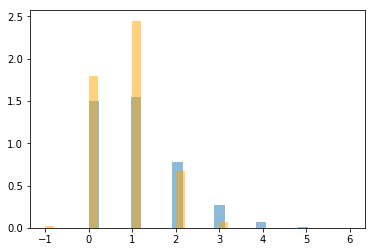

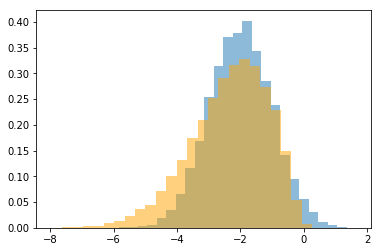

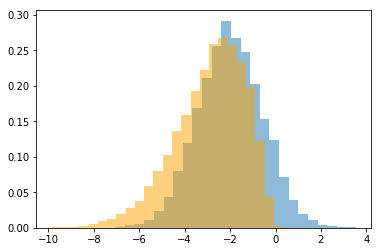

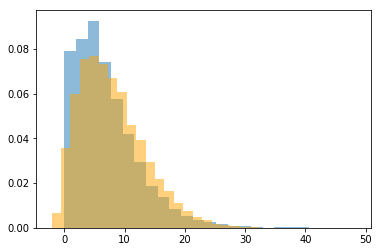

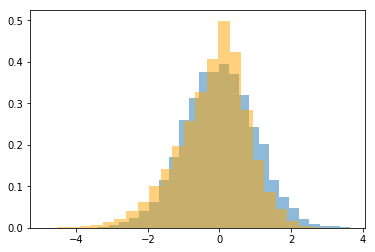

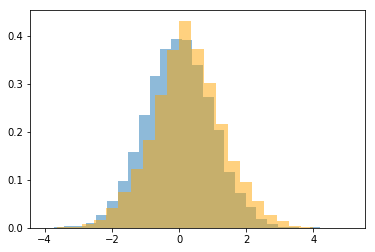

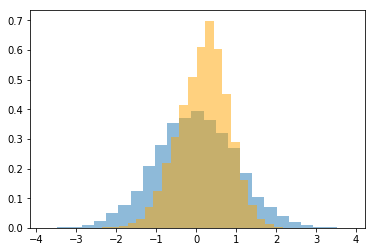

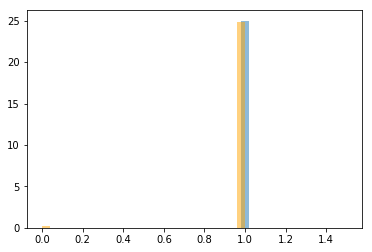

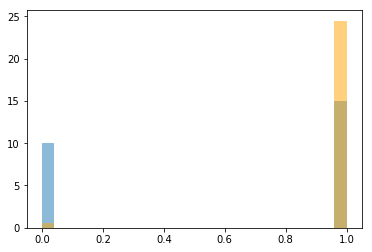

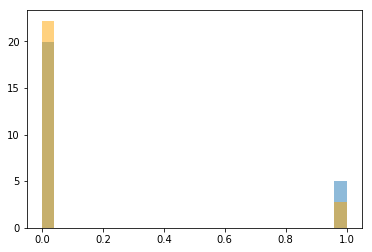

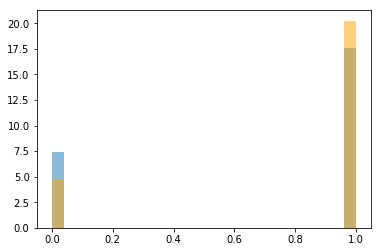

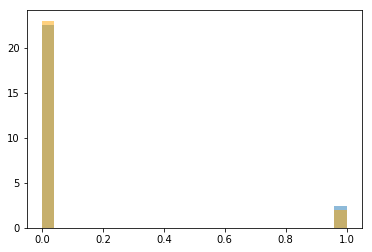

In [363]:
for i in range(real.shape[1]):
    plt.hist(real.groupby("group").get_group(1).iloc[:,i], alpha=0.5, bins=25, density=True)
    plt.hist(fake.iloc[:,i], alpha=0.5, bins=25, density=True, color="orange")
    plt.show()

## Model performance

In [364]:
training.groupby("group").size()

group
0.0    19000
1.0     1000
dtype: int64

In [378]:
sample = pd.DataFrame(wgan.generator.sample(make_noise(18000, dim=wgan.generator.noise_dim)).detach().numpy())
sample.rename({7:"group"}, axis="columns", inplace=True)

In [379]:
training_upsampled = pd.concat([training, 
                               sample]
                                )

In [380]:
X_train_org = training.drop("group", axis=1)
y_train_org = training.group.values

clf = DecisionTreeClassifier(min_samples_leaf=50, random_state=123)
clf.fit(X_train_org, y_train_org)
pred_org = clf.predict(test.drop("group", axis=1).values)


### GANbalance

In [381]:
X_train_up = training_upsampled.drop("group", axis=1)
y_train_up = training_upsampled.group.values

clf = DecisionTreeClassifier(min_samples_leaf=50, random_state=123)
clf.fit(X_train_up, y_train_up)
pred_up = clf.predict(test.drop("group", axis=1).values)

### SMOTE

In [264]:
X_train_cat = X_train_org.drop([9,10,11], axis=1)
X_train_cat[9] = X_train_org.iloc[:,8:11].idxmax(axis=1)

In [265]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0,7,8], random_state=0, njobs=10)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train_cat, y_train_org)

In [266]:
X_train_smote = pd.DataFrame(X_train_smote)
X_train_smote = pd.get_dummies(X_train_smote, columns=[8])

In [267]:
clf = DecisionTreeClassifier(min_samples_leaf=50, random_state=123)
clf.fit(X_train_smote, y_train_smote)
pred_smote = clf.predict(test.drop("group", axis=1).values)

### Comparison

In [382]:
print(roc_auc_score(test.group.values, pred_org))
print(roc_auc_score(test.group.values, pred_smote))
print(roc_auc_score(test.group.values, pred_up))

0.9532894736842106
0.9799473684210526
0.9653157894736842
